In [1]:
using ModelingToolkit, IntervalSets, Sophon, CairoMakie, Lux
using Optimization, OptimizationOptimJL

@parameters x,t
@variables θ(..), w(..), α(..)
Dₜ = Differential(t)
Dₜ² = Differential(t)^2
Dₓ = Differential(x)
Dₓ² = Differential(x)^2

g(x,t) = cos(t) - π/2 * sin(x)*cos(t)

eqs = [
    α(x,t) * Dₜ²(θ(x,t)) - Dₓ²(θ(x,t)) + θ(x,t) - Dₓ(w(x,t)) ~ 0.0,
    Dₜ²(w(x,t)) - Dₓ²(w(x,t)) + Dₓ(θ(x,t)) ~ g(x,t)]

bcs = [
    θ(x, 0.0) ~ π/2*cos(x) + x - π/2,
    Dₜ(θ(x, 0.0)) ~ 0.0,
    w(x, 0.0) ~ π/2*sin(x),
    Dₜ(w(x, 0.0)) ~ 0.0,
    θ(0.0, t) ~ 0.0,
    θ(π, t) ~ 0.0,
    w(0.0, t) ~ 0.0, 
    w(π, t) ~ 0.0]

    
domains = [x ∈ Interval(0.0, π),
           t ∈ Interval(0.0, 1.0)]

@named timo = PDESystem(eqs, bcs, domains, [x,t], [θ(x,t),w(x,t),α(x,t)])

PDESystem
Equations: Equation[Differential(t)(Differential(t)(θ(x, t)))*α(x, t) + θ(x, t) - Differential(x)(Differential(x)(θ(x, t))) - Differential(x)(w(x, t)) ~ 0.0, Differential(t)(Differential(t)(w(x, t))) + Differential(x)(θ(x, t)) - Differential(x)(Differential(x)(w(x, t))) ~ cos(t) - 1.5707963267948966cos(t)*sin(x)]
Boundary Conditions: Equation[θ(x, 0.0) ~ x + 1.5707963267948966cos(x) - 1.5707963267948966, Differential(t)(θ(x, 0.0)) ~ 0.0, w(x, 0.0) ~ 1.5707963267948966sin(x), Differential(t)(w(x, 0.0)) ~ 0.0, θ(0.0, t) ~ 0.0, θ(π, t) ~ 0.0, w(0.0, t) ~ 0.0, w(π, t) ~ 0.0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, 0.0..3.141592653589793), Symbolics.VarDomainPairing(t, 0.0..1.0)]
Dependent Variables: Num[θ(x, t), w(x, t), α(x, t)]
Independent Variables: Num[x, t]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [2]:
pinn = PINN(θ = FullyConnected(2,1, tanh; hidden_dims=16,num_layers=3),
            w = FullyConnected(2,1, tanh; hidden_dims=16,num_layers=3),
            α = ConstantFunction())

sampler = QuasiRandomSampler(2000, 500)
strategy = NonAdaptiveTraining(1, 10)

NonAdaptiveTraining{Int64, Int64}(1, 10)

In [36]:
# generate training data
x_train = [0.2,0.8,1.8,2.6,3.0]
t_train = 0.0:0.001:1.0
θ_analytic(x,t) = (π/2*cos(x) + x - π/2)*cos(t) + randn()*0.001
w_analytic(x,t) = π/2*sin(x)*cos(t)+ randn()*0.001

coord_data = stack(vec(vcat.(x_train, t_train')))
θ_data = reshape(θ_analytic.(x_train, t_train'), 1, :)
w_data = reshape(w_analytic.(x_train, t_train'), 1, :)

1×5005 Matrix{Float64}:
 0.309799  1.12785  1.52967  0.808926  …  0.825683  0.436815  0.1196

In [37]:
function additional_loss(phi, ps)
    (sum(abs2, phi.θ(coord_data, ps.θ) .- θ_data) + sum(abs2, phi.w(coord_data, ps.w) .- w_data))/50000
end

additional_loss (generic function with 1 method)

In [38]:
prob = Sophon.discretize(timo, pinn, sampler, strategy; additional_loss=additional_loss)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(θ = (layer_1 = (weight = [1.6476097106933594 1.4977024793624878; 1.8836112022399902 0.21934503316879272; … ; -0.039989177137613297 -1.391273856163025; 1.1705420017242432 1.6364364624023438], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.6377987265586853 -0.38341203331947327 … -0.5294045209884644 0.31917813420295715; -0.6222934126853943 -0.2385936975479126 … 0.4571743905544281 -0.09764963388442993; … ; -0.40452840924263 0.2238221913576126 … 0.017607802525162697 -0.44051870703697205; -0.07949381321668625 -0.3068926930427551 … -0.2154524177312851 0.22555513679981232], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.15044447779655457 0.16066300868988037 … 0.5732495188713074 0.38888537883758545; 0.3838922679424286 0.2581866979598999 … 0.03208464756608009 -0.7167654037475586; … ; -0.4169015884399414 0.22505933046340942 … 0.12516926229000092 0.2561468780040741; -0.04063638672232628 0.32622775435447693 … -

In [40]:
function callback(p, l)
    println("Loss: $l")
    return false
end

res = Optimization.solve(prob, BFGS(); maxiters=2000, callback=callback)

Loss: 270.6625347179377


Loss: 39.79417434793755


Loss: 21.165769463710674


Loss: 20.194582969753554


Loss: 17.192899035676877


Loss: 14.872602561578912


Loss: 14.013028233483434


Loss: 12.018518809042071


Loss: 10.500271657373515


Loss: 8.837480507075405


Loss: 7.86944192432977


Loss: 6.806816916995499


Loss: 5.96477448309459


Loss: 5.793620248207418


Loss: 5.133758721666013


Loss: 4.664923662098355


Loss: 4.037900773787064


Loss: 3.616644711711639


Loss: 3.2635327394115414


Loss: 3.0269337525206406


Loss: 2.693600620019794


Loss: 2.4580855913783


Loss: 2.309324350612363


Loss: 2.173054227588984


Loss: 1.9675376626404368


Loss: 1.7801551519579368


Loss: 1.687859713279301


Loss: 1.4841325085140602


Loss: 1.2465596834576276


Loss: 1.1661040793872086


Loss: 1.0660351415070377


Loss: 0.9997432416699694


Loss: 0.9168491516225152


Loss: 0.8650134926686537


Loss: 0.815424022226846


Loss: 0.7891431427076948


Loss: 0.7685706207969174


Loss: 0.7489968663151256


Loss: 0.7329369532700438


Loss: 0.7203091132481922


Loss: 0.702174468386748


Loss: 0.6949130836835017


Loss: 0.6637706664256484


Loss: 0.6562424465864857


Loss: 0.6462824750218464


Loss: 0.6320479703077956


Loss: 0.6037039908343557


Loss: 0.5802315709777935


Loss: 0.5645832124202943


Loss: 0.5558399709110574


Loss: 0.5504287872798188


Loss: 0.545646825169441


Loss: 0.5399314455606304


Loss: 0.5192530164625702


Loss: 0.5067960877563554


Loss: 0.4618365555189536


Loss: 0.44580197543327776


Loss: 0.43562565430747435


Loss: 0.4234050732568641


Loss: 0.4096658672331448


Loss: 0.40228356473696986


Loss: 0.37774948606293374


Loss: 0.36457600174142374


Loss: 0.34043233323274513


Loss: 0.31704953961619453


Loss: 0.3090534516972088


Loss: 0.2906765520441097


Loss: 0.28334072900921153


Loss: 0.27812993855914775


Loss: 0.2551627834728423


Loss: 0.21491637599118488


Loss: 0.204903859500743


Loss: 0.2007065878929192


Loss: 0.18476981616080299


Loss: 0.1513001677256034


Loss: 0.1354844034807619


Loss: 0.12737641711405015


Loss: 0.12149864147557037


Loss: 0.1153711187016887


Loss: 0.10172236848615415


Loss: 0.09366441748878379


Loss: 0.08740250346247141


Loss: 0.07193524845264651


Loss: 0.060982614054399656


Loss: 0.05809576440173867


Loss: 0.054256512655278144


Loss: 0.05168181212588412


Loss: 0.048146337587034224


Loss: 0.04706024381995564


Loss: 0.04425136048470698


Loss: 0.03873600663151771


Loss: 0.036000622922133456


Loss: 0.03162594362175731


Loss: 0.029387481635392843


Loss: 0.027887501694021485


Loss: 0.02597377330174522


Loss: 0.024958613388675457


Loss: 0.023606970577264037


Loss: 0.022926971142204856


Loss: 0.022137071344717735


Loss: 0.020652191230625342


Loss: 0.019896608865705503


Loss: 0.019541173462537084


Loss: 0.018802850977948742


Loss: 0.017999324234132186


Loss: 0.016885650536921534


Loss: 0.015576695670143493


Loss: 0.014572268182443766


Loss: 0.013749789427410578


Loss: 0.012949129497209264


Loss: 0.012052391050625026


Loss: 0.011069793242736806


Loss: 0.010018912439038335


Loss: 0.009189807816061525


Loss: 0.008422957278366


Loss: 0.007733385709771229


Loss: 0.007375266474903856


Loss: 0.007053935408571523


Loss: 0.0066020323072379025


Loss: 0.006013817596426508


Loss: 0.00550124297023023


Loss: 0.0050526951262917985


Loss: 0.004776936541010397


Loss: 0.004505238793764163


Loss: 0.004338085626813628


Loss: 0.004168005495855628


Loss: 0.00398166747953422


Loss: 0.003781445799840436


Loss: 0.003617913044107304


Loss: 0.0034982350953366697


Loss: 0.0033739665892304357


Loss: 0.0032539952283534663


Loss: 0.00309384931777142


Loss: 0.00295258981429031


Loss: 0.00275723865484773


Loss: 0.002620706541267764


Loss: 0.002512262179337223


Loss: 0.002359318958719013


Loss: 0.002270579946107985


Loss: 0.0021611420004988956


Loss: 0.0020121839450890073


Loss: 0.0018831579970139036


Loss: 0.0018090414491778169


Loss: 0.0017275034152299167


Loss: 0.0016379348903317276


Loss: 0.0015705728777231504


Loss: 0.0014993671038999485


Loss: 0.0014288597774435921


Loss: 0.0013720466591706163


Loss: 0.0013111672453583868


Loss: 0.001254103682192628


Loss: 0.0011922462907253944


Loss: 0.0011385553922512472


Loss: 0.001089021702201843


Loss: 0.0010374593895647651


Loss: 0.0010047799299392572


Loss: 0.0009719018145465033


Loss: 0.000932343776712625


Loss: 0.0008992597839786202


Loss: 0.000844253515802492


Loss: 0.0008212277673765073


Loss: 0.0007888105199994535


Loss: 0.0007635738566494122


Loss: 0.000733595045002133


Loss: 0.0007034079764629154


Loss: 0.0006633889832267455


Loss: 0.0006389905002047477


Loss: 0.0006059917931033808


Loss: 0.000581689085452065


Loss: 0.0005590683010516403


Loss: 0.0005382529774416859


Loss: 0.0005238491709205308


Loss: 0.0004984215322092742


Loss: 0.0004721861553710926


Loss: 0.00045226689558651684


Loss: 0.0004367691526768339


Loss: 0.00042496768373227013


Loss: 0.00041541888619246015


Loss: 0.0004066003515528723


Loss: 0.00040004384864950336


Loss: 0.000390435363741898


Loss: 0.0003814436225612437


Loss: 0.0003715427588184202


Loss: 0.0003652136401498164


Loss: 0.0003586054808588931


Loss: 0.0003531646220624973


Loss: 0.000346821308163085


Loss: 0.0003419407773071386


Loss: 0.00033636414295636335


Loss: 0.0003323602263191164


Loss: 0.0003281126294927103


Loss: 0.0003237168662182633


Loss: 0.00031869037871266024


Loss: 0.00031426132894063057


Loss: 0.0003069956137822334


Loss: 0.00029794871975469874


Loss: 0.00028957986579989064


Loss: 0.00028501845585098256


Loss: 0.00028108751034743577


Loss: 0.0002778129146183358


Loss: 0.0002745343679997474


Loss: 0.0002709152268313024


Loss: 0.0002680992853414584


Loss: 0.0002655514439734556


Loss: 0.00026341251920954047


Loss: 0.0002609352512774874


Loss: 0.00025841477545334715


Loss: 0.00025612443326322824


Loss: 0.0002529486430183405


Loss: 0.00024879982853272286


Loss: 0.0002461383116730726


Loss: 0.00024293731261492102


Loss: 0.00023998011732269734


Loss: 0.00023712385810570363


Loss: 0.00023440475407190785


Loss: 0.00023184227329510547


Loss: 0.0002294589858081915


Loss: 0.0002269930874087094


Loss: 0.00022420405120577474


Loss: 0.00022125731552172763


Loss: 0.00021845013436895243


Loss: 0.00021656714791949125


Loss: 0.00021379225458301673


Loss: 0.00021054496553576019


Loss: 0.00020740045971343838


Loss: 0.0002045380440124469


Loss: 0.000201968541853787


Loss: 0.00019984115287910155


Loss: 0.00019757966440703213


Loss: 0.0001952237792897901


Loss: 0.00019235814456455548


Loss: 0.00019027047007160402


Loss: 0.00018783970954928963


Loss: 0.00018607213196286513


Loss: 0.00018463875385761087


Loss: 0.00018241599056148514


Loss: 0.00017968889507812488


Loss: 0.00017782206156102728


Loss: 0.000176189092581373


Loss: 0.0001741614406889546


Loss: 0.00017263171583843185


Loss: 0.00017178649463312894


Loss: 0.00017106661078595812


Loss: 0.0001703951267408155


Loss: 0.00016961586571350828


Loss: 0.00016848605809205062


Loss: 0.0001665369624982409


Loss: 0.00016367270111783194


Loss: 0.00016170967696728717


Loss: 0.00016012698174574207


Loss: 0.0001591956904530638


Loss: 0.00015754214890407683


Loss: 0.00015646744495179088


Loss: 0.00015548564336980022


Loss: 0.0001546076772193146


Loss: 0.00015397696603246117


Loss: 0.0001530467959342631


Loss: 0.0001516966947006852


Loss: 0.00015060691535417187


Loss: 0.00014985239740991437


Loss: 0.00014910739347663923


Loss: 0.00014837578494342633


Loss: 0.0001474617123140184


Loss: 0.00014651888853559015


Loss: 0.0001453939344058299


Loss: 0.00014424437643229692


Loss: 0.0001433553584004792


Loss: 0.00014225474483373052


Loss: 0.00014137512472030118


Loss: 0.00014054350497595222


Loss: 0.00013954628775478937


Loss: 0.00013891203189594876


Loss: 0.0001383328348809828


Loss: 0.00013752388844626905


Loss: 0.000136149259436277


Loss: 0.00013453808954704604


Loss: 0.00013316384961897302


Loss: 0.00013228765487911803


Loss: 0.00013168962049629594


Loss: 0.00013127696967784512


Loss: 0.00013093540160316153


Loss: 0.00013043523647064524


Loss: 0.00012988190024364464


Loss: 0.00012912055561874544


Loss: 0.0001285211728584231


Loss: 0.00012783436489343834


Loss: 0.0001269708538577337


Loss: 0.00012613196407429457


Loss: 0.00012546105754663287


Loss: 0.0001251110434194646


Loss: 0.0001245951245239251


Loss: 0.00012381237313664352


Loss: 0.0001230169208059993


Loss: 0.00012215320315176405


Loss: 0.00012144705653032735


Loss: 0.00012075865911605346


Loss: 0.00012012728235471332


Loss: 0.00011981786881005437


Loss: 0.00011948553411357277


Loss: 0.00011906703242540258


Loss: 0.00011810516396793426


Loss: 0.00011742027121503873


Loss: 0.00011677895214554843


Loss: 0.000115901244166905


Loss: 0.0001152790761666008


Loss: 0.00011485312167349289


Loss: 0.00011447144424950048


Loss: 0.00011389416143876802


Loss: 0.00011314007822364787


Loss: 0.00011266861111667908


Loss: 0.00011218342663535148


Loss: 0.00011174357525932377


Loss: 0.00011123896719878904


Loss: 0.00011074557454018364


Loss: 0.00011025985367718497


Loss: 0.00010980641811754647


Loss: 0.00010932391136628039


Loss: 0.00010872154936645022


Loss: 0.00010804307527546434


Loss: 0.00010763829426285498


Loss: 0.00010706535748719031


Loss: 0.00010659823783067235


Loss: 0.0001059264954893656


Loss: 0.00010509454042675236


Loss: 0.00010431363639798784


Loss: 0.00010367452952584746


Loss: 0.00010316085267127622


Loss: 0.00010280577659361524


Loss: 0.00010255367828289489


Loss: 0.00010233662167673942


Loss: 0.000101955418497883


Loss: 0.00010149464792592677


Loss: 0.00010098430148685082


Loss: 0.0001005575289632558


Loss: 0.0001000082791230472


Loss: 9.947307123519687e-5


Loss: 9.893218827326323e-5


Loss: 9.843570657549598e-5


Loss: 9.791571578891852e-5


Loss: 9.747416107815145e-5


Loss: 9.698113144595935e-5


Loss: 9.63619941512817e-5


Loss: 9.575487397747807e-5


Loss: 9.514372195974994e-5


Loss: 9.436131061501835e-5


Loss: 9.363223430983546e-5


Loss: 9.285760719356445e-5


Loss: 9.21051823534733e-5


Loss: 9.145566335283434e-5


Loss: 9.108101256986403e-5


Loss: 9.077083884520738e-5


Loss: 9.052755175635994e-5


Loss: 9.030547095370619e-5


Loss: 9.006634408986356e-5


Loss: 8.986967940021411e-5


Loss: 8.969276280729661e-5


Loss: 8.949007066214469e-5


Loss: 8.912946645906424e-5


Loss: 8.872102625102474e-5


Loss: 8.814365382409567e-5


Loss: 8.76848557908902e-5


Loss: 8.734261669901528e-5


Loss: 8.686258653207556e-5


Loss: 8.622380405000075e-5


Loss: 8.563433628287577e-5


Loss: 8.523392114480446e-5


Loss: 8.488450205137902e-5


Loss: 8.461086390364653e-5


Loss: 8.425495561847194e-5


Loss: 8.382029898252162e-5


Loss: 8.346505315889324e-5


Loss: 8.318485783677242e-5


Loss: 8.281564487318798e-5


Loss: 8.236579574857084e-5


Loss: 8.189292474988585e-5


Loss: 8.137463213083086e-5


Loss: 8.050662365366034e-5


Loss: 7.983982663077177e-5


Loss: 7.936459052826238e-5


Loss: 7.903723413318542e-5


Loss: 7.877698392699292e-5


Loss: 7.862230241595993e-5


Loss: 7.847746858143776e-5


Loss: 7.827007724946291e-5


Loss: 7.797951936873481e-5


Loss: 7.762382057252432e-5


Loss: 7.729454853059869e-5


Loss: 7.68326007224153e-5


Loss: 7.647543649154557e-5


Loss: 7.604871001860842e-5


Loss: 7.56732230263018e-5


Loss: 7.520195070525066e-5


Loss: 7.458499289826528e-5


Loss: 7.403216474517437e-5


Loss: 7.353747836475114e-5


Loss: 7.305543415916489e-5


Loss: 7.255118507573153e-5


Loss: 7.221379930308972e-5


Loss: 7.194250443335031e-5


Loss: 7.175059570227812e-5


Loss: 7.149510369495326e-5


Loss: 7.119249801752241e-5


Loss: 7.082971899601584e-5


Loss: 7.021022962968882e-5


Loss: 6.973602561947476e-5


Loss: 6.942342725896637e-5


Loss: 6.909325312556077e-5


Loss: 6.882982823965725e-5


Loss: 6.850183848450088e-5


Loss: 6.819564724888923e-5


Loss: 6.799916122321608e-5


Loss: 6.781859497353177e-5


Loss: 6.758918901186319e-5


Loss: 6.735373222110035e-5


Loss: 6.703802071169626e-5


Loss: 6.673829819841613e-5


Loss: 6.649077184581446e-5


Loss: 6.614340103277015e-5


Loss: 6.570352961716188e-5


Loss: 6.51371130255566e-5


Loss: 6.451185712753391e-5


Loss: 6.396882230963469e-5


Loss: 6.367057807223943e-5


Loss: 6.355702288620609e-5


Loss: 6.33506111670317e-5


Loss: 6.31072820140366e-5


Loss: 6.284555833376227e-5


Loss: 6.259714296730853e-5


Loss: 6.231764270757333e-5


Loss: 6.19792046390755e-5


Loss: 6.171503930844874e-5


Loss: 6.150274623373494e-5


Loss: 6.11172241572872e-5


Loss: 6.0658351377309655e-5


Loss: 6.013757641839366e-5


Loss: 5.9650945701982036e-5


Loss: 5.922729361922477e-5


Loss: 5.8899601457840583e-5


Loss: 5.8739042862771114e-5


Loss: 5.8585893039251736e-5


Loss: 5.8381904465171726e-5


Loss: 5.810682433958908e-5


Loss: 5.758468815778043e-5


Loss: 5.687744664268656e-5


Loss: 5.6258890899440946e-5


Loss: 5.580476611704482e-5


Loss: 5.5401312158888894e-5


Loss: 5.50217410595321e-5


Loss: 5.4796737240105764e-5


Loss: 5.4561383458414254e-5


Loss: 5.427386664373014e-5


Loss: 5.406071896173091e-5


Loss: 5.381416703384408e-5


Loss: 5.3612090021605155e-5


Loss: 5.3434814619433694e-5


Loss: 5.325870559924095e-5


Loss: 5.297001984905992e-5


Loss: 5.270938818918083e-5


Loss: 5.252450295662661e-5


Loss: 5.234097371530546e-5


Loss: 5.221423581700958e-5


Loss: 5.206129795508621e-5


Loss: 5.189993333362083e-5


Loss: 5.167287128885277e-5


Loss: 5.141967325146545e-5


Loss: 5.109471218555907e-5


Loss: 5.0889670603126394e-5


Loss: 5.060607702672083e-5


Loss: 5.039400743983231e-5


Loss: 5.022449534971254e-5


Loss: 5.003103589580509e-5


Loss: 4.989927126651727e-5


Loss: 4.9708877869605655e-5


Loss: 4.9511614399564476e-5


Loss: 4.926131568938361e-5


Loss: 4.9040424435883186e-5


Loss: 4.883077188388311e-5


Loss: 4.86382820887671e-5


Loss: 4.850785815483016e-5


Loss: 4.838716442957466e-5


Loss: 4.8240445319226467e-5


Loss: 4.8077520045092026e-5


Loss: 4.794918033760757e-5


Loss: 4.784427609936372e-5


Loss: 4.774672256987259e-5


Loss: 4.764816235577776e-5


Loss: 4.757070185681282e-5


Loss: 4.74745978860533e-5


Loss: 4.734343952766271e-5


Loss: 4.720170372307616e-5


Loss: 4.708037169036511e-5


Loss: 4.69201026013683e-5


Loss: 4.673142505267917e-5


Loss: 4.643808639497547e-5


Loss: 4.6134596279526456e-5


Loss: 4.5830004988079916e-5


Loss: 4.5480827371793336e-5


Loss: 4.510143564249777e-5


Loss: 4.476700818956941e-5


Loss: 4.4566993517280794e-5


Loss: 4.435073147991225e-5


Loss: 4.41972600292148e-5


Loss: 4.402319456586861e-5


Loss: 4.3856253110431074e-5


Loss: 4.3732629932517655e-5


Loss: 4.3629570272648465e-5


Loss: 4.353513715223302e-5


Loss: 4.342752119419794e-5


Loss: 4.324054379077758e-5


Loss: 4.29650883446178e-5


Loss: 4.275470953286777e-5


Loss: 4.2591623754507754e-5


Loss: 4.2410042357096734e-5


Loss: 4.21386873674383e-5


Loss: 4.1898476143191116e-5


Loss: 4.1692828943379975e-5


Loss: 4.1465802557336184e-5


Loss: 4.1248051142922954e-5


Loss: 4.1045357557909595e-5


Loss: 4.076757134205831e-5


Loss: 4.04808453781537e-5


Loss: 4.027851550724825e-5


Loss: 4.006951764364379e-5


Loss: 3.989204962072577e-5


Loss: 3.97728168957811e-5


Loss: 3.969948280856857e-5


Loss: 3.954627847857434e-5


Loss: 3.941538133536196e-5


Loss: 3.921611782475951e-5


Loss: 3.906107665924991e-5


Loss: 3.8937921991714905e-5


Loss: 3.884034692090382e-5


Loss: 3.872468291373176e-5


Loss: 3.860271191238603e-5


Loss: 3.8489238367920905e-5


Loss: 3.8396563009189484e-5


Loss: 3.827952873932725e-5


Loss: 3.8174463289436766e-5


Loss: 3.806225516437835e-5


Loss: 3.79828354730845e-5


Loss: 3.789591573262488e-5


Loss: 3.7812274879595346e-5


Loss: 3.772998087622892e-5


Loss: 3.763459953941509e-5


Loss: 3.749839247279949e-5


Loss: 3.731436688440315e-5


Loss: 3.7123593957325045e-5


Loss: 3.695492848682581e-5


Loss: 3.6815987246645226e-5


Loss: 3.6685155255531106e-5


Loss: 3.653252988107051e-5


Loss: 3.632807262126709e-5


Loss: 3.614725016693285e-5


Loss: 3.5995466745529884e-5


Loss: 3.586530353294168e-5


Loss: 3.5747833774665245e-5


Loss: 3.561351987596522e-5


Loss: 3.548406663707943e-5


Loss: 3.528032578037015e-5


Loss: 3.5091788044373395e-5


Loss: 3.491245078578792e-5


Loss: 3.476318491476531e-5


Loss: 3.464138739860347e-5


Loss: 3.4562500675705483e-5


Loss: 3.448024122309634e-5


Loss: 3.4348822383154336e-5


Loss: 3.4237905489212424e-5


Loss: 3.407083031381247e-5


Loss: 3.3914133764916286e-5


Loss: 3.3837834059408644e-5


Loss: 3.36779182438222e-5


Loss: 3.353631138177324e-5


Loss: 3.341581849576614e-5


Loss: 3.324884704065261e-5


Loss: 3.301925268224709e-5


Loss: 3.29138463113994e-5


Loss: 3.27594859639218e-5


Loss: 3.261094361489365e-5


Loss: 3.2452153004285965e-5


Loss: 3.2291671914092724e-5


Loss: 3.210260203490807e-5


Loss: 3.191839998851414e-5


Loss: 3.1774278928350114e-5


Loss: 3.159847555039757e-5


Loss: 3.143133973800253e-5


Loss: 3.1221111864320024e-5


Loss: 3.1047714430384606e-5


Loss: 3.086627738722577e-5


Loss: 3.072838001550444e-5


Loss: 3.058396003688001e-5


Loss: 3.043245580649697e-5


Loss: 3.029420220514933e-5


Loss: 3.01533833408924e-5


Loss: 3.0006109664167846e-5


Loss: 2.9883084760622005e-5


Loss: 2.9758457174372153e-5


Loss: 2.963611639148844e-5


Loss: 2.9499738929168464e-5


Loss: 2.937991168751681e-5


Loss: 2.925972006324819e-5


Loss: 2.9180107304114198e-5


Loss: 2.909882192738255e-5


Loss: 2.9050590838929297e-5


Loss: 2.8976517427266007e-5


Loss: 2.8849665238942482e-5


Loss: 2.8649806308347777e-5


Loss: 2.846907007307148e-5


Loss: 2.8263079694970848e-5


Loss: 2.8057516657869955e-5


Loss: 2.786833782584093e-5


Loss: 2.7726161571689105e-5


Loss: 2.7538234441659845e-5


Loss: 2.741164172969623e-5


Loss: 2.7328496812864014e-5


Loss: 2.723577748302301e-5


Loss: 2.7126348156837464e-5


Loss: 2.703144126703768e-5


Loss: 2.6941311664909658e-5


Loss: 2.6875072370204585e-5


Loss: 2.6817480899148964e-5


Loss: 2.673658684753751e-5


Loss: 2.6663294896556724e-5


Loss: 2.657720573077707e-5


Loss: 2.6471448441989537e-5


Loss: 2.629951687667812e-5


Loss: 2.6125687125976907e-5


Loss: 2.5924785653871663e-5


Loss: 2.5659337938597366e-5


Loss: 2.528464179180844e-5


Loss: 2.5035852294209844e-5


Loss: 2.482578554489217e-5


Loss: 2.452262858651274e-5


Loss: 2.4339580134592063e-5


Loss: 2.411641377266712e-5


Loss: 2.3965550100858384e-5


Loss: 2.3792306595060824e-5


Loss: 2.3695023181221265e-5


Loss: 2.357031888934596e-5


Loss: 2.3469314816652448e-5


Loss: 2.3390791692872983e-5


Loss: 2.331743084062464e-5


Loss: 2.3229785847948344e-5


Loss: 2.3124187936240217e-5


Loss: 2.2989108322533716e-5


Loss: 2.283734323359595e-5


Loss: 2.2641106055898407e-5


Loss: 2.252978240113163e-5


Loss: 2.2291779410390924e-5


Loss: 2.2216925361420457e-5


Loss: 2.2103018185954534e-5


Loss: 2.1986444991017795e-5


Loss: 2.1911279330686335e-5


Loss: 2.1831805356845847e-5


Loss: 2.1749679130516663e-5


Loss: 2.1635654688884396e-5


Loss: 2.1500459428098586e-5


Loss: 2.1319165562869814e-5


Loss: 2.1146683222018905e-5


Loss: 2.0959128002724123e-5


Loss: 2.0807720680587485e-5


Loss: 2.0582538886324934e-5


Loss: 2.0464608112664956e-5


Loss: 2.027124387092936e-5


Loss: 2.010277508295545e-5


Loss: 1.987967327124122e-5


Loss: 1.9733718645391153e-5


Loss: 1.9572274786557425e-5


Loss: 1.938471604521032e-5


Loss: 1.9231824493907836e-5


Loss: 1.911671266338075e-5


Loss: 1.9023682110147178e-5


Loss: 1.896946054258952e-5


Loss: 1.891930178261408e-5


Loss: 1.886862821698548e-5


Loss: 1.8804536018738714e-5


Loss: 1.874967602894727e-5


Loss: 1.8697760050281868e-5


Loss: 1.859855480248381e-5


Loss: 1.8517990769286057e-5


Loss: 1.843582487820126e-5


Loss: 1.8363359478626208e-5


Loss: 1.8299506830486846e-5


Loss: 1.8222067026686226e-5


Loss: 1.8151092126577305e-5


Loss: 1.8078742171883766e-5


Loss: 1.7966418793752922e-5


Loss: 1.780359998888624e-5


Loss: 1.7586036543436406e-5


Loss: 1.743301145828051e-5


Loss: 1.7329349504984242e-5


Loss: 1.7227948602739107e-5


Loss: 1.711691738184036e-5


Loss: 1.6989430233661173e-5


Loss: 1.6901556071362767e-5


Loss: 1.681048642965378e-5


Loss: 1.668952061624711e-5


Loss: 1.655992614557742e-5


Loss: 1.6438166220177377e-5


Loss: 1.630398063699816e-5


Loss: 1.620629633744679e-5


Loss: 1.6096963058532115e-5


Loss: 1.6004046428853507e-5


Loss: 1.594040829796741e-5


Loss: 1.583672526331324e-5


Loss: 1.5731567329774504e-5


Loss: 1.5633698532031308e-5


Loss: 1.557313033664438e-5


Loss: 1.5525542461328726e-5


Loss: 1.5469365654841435e-5


Loss: 1.5441269237457114e-5


Loss: 1.5400224453265037e-5


Loss: 1.5341691314888348e-5


Loss: 1.526388672157412e-5


Loss: 1.5180400238634187e-5


Loss: 1.508060081760477e-5


Loss: 1.4991475832919503e-5


Loss: 1.4902580869024647e-5


Loss: 1.4827255618913767e-5


Loss: 1.4748114851800168e-5


Loss: 1.4677228352639036e-5


Loss: 1.4615824546199078e-5


Loss: 1.4543785132037949e-5


Loss: 1.4463719005998903e-5


Loss: 1.4371973130720726e-5


Loss: 1.4299282832046632e-5


Loss: 1.4218083341429866e-5


Loss: 1.4127825021148997e-5


Loss: 1.4049321971473987e-5


Loss: 1.3936627360711007e-5


Loss: 1.383484135444851e-5


Loss: 1.373908761759415e-5


Loss: 1.3639731483384861e-5


Loss: 1.3574174399436706e-5


Loss: 1.3534017699053926e-5


Loss: 1.3486840934520895e-5


Loss: 1.3437602165043223e-5


Loss: 1.3380910356692113e-5


Loss: 1.3316518729361312e-5


Loss: 1.3245131827802771e-5


Loss: 1.3185155430517396e-5


Loss: 1.31490515280719e-5


Loss: 1.3117878207697292e-5


Loss: 1.3083245820713757e-5


Loss: 1.3042355796943075e-5


Loss: 1.2995700580708973e-5


Loss: 1.2927055738198243e-5


Loss: 1.2860554513824695e-5


Loss: 1.2805285786337615e-5


Loss: 1.2761737468610434e-5


Loss: 1.2720887643028643e-5


Loss: 1.2629552781706414e-5


Loss: 1.2547767397910924e-5


Loss: 1.2442418697369924e-5


Loss: 1.2365346181662037e-5


Loss: 1.2289636661500245e-5


Loss: 1.2214441338929378e-5


Loss: 1.2163733092074925e-5


Loss: 1.2127172070015889e-5


Loss: 1.2090830503987746e-5


Loss: 1.2042850378093787e-5


Loss: 1.198314010425732e-5


Loss: 1.1925397605209416e-5


Loss: 1.1879034086262353e-5


Loss: 1.1838832756732174e-5


Loss: 1.1782229111072699e-5


Loss: 1.1715832608010434e-5


Loss: 1.1646982409628304e-5


Loss: 1.1579263001808852e-5


Loss: 1.1528605625303624e-5


Loss: 1.1482975484177224e-5


Loss: 1.1443585733067282e-5


Loss: 1.1410519073595319e-5


Loss: 1.1358350337216277e-5


Loss: 1.1303026499810298e-5


Loss: 1.125543520622965e-5


Loss: 1.1199290154364315e-5


Loss: 1.1157077068029472e-5


Loss: 1.112384939105546e-5


Loss: 1.1101961540270351e-5


Loss: 1.1071588873172678e-5


Loss: 1.1039893558501142e-5


Loss: 1.101158545163445e-5


Loss: 1.0972557081760363e-5


Loss: 1.092197161068926e-5


Loss: 1.0833474296162523e-5


Loss: 1.071871228177681e-5


Loss: 1.0584751857994268e-5


Loss: 1.053957066912837e-5


Loss: 1.0467624147457642e-5


Loss: 1.0431536076619936e-5


Loss: 1.0406715739696582e-5


Loss: 1.037658717247937e-5


Loss: 1.0349612237734778e-5


Loss: 1.0325961841132804e-5


Loss: 1.0303302717698598e-5


Loss: 1.0281155370028153e-5


Loss: 1.0255669844258587e-5


Loss: 1.0218068707438882e-5


Loss: 1.0170279512658564e-5


Loss: 1.0112189560451143e-5


Loss: 1.0058178896931812e-5


Loss: 1.0013197848171943e-5


Loss: 9.987186822827265e-6


Loss: 9.955761467394902e-6


Loss: 9.921793171216898e-6


Loss: 9.875751768028001e-6


Loss: 9.818673928818892e-6


Loss: 9.758596140861629e-6


Loss: 9.708050591447833e-6


Loss: 9.63947491522956e-6


Loss: 9.565830076334348e-6


Loss: 9.464136922056527e-6


Loss: 9.372957322304717e-6


Loss: 9.260898185591642e-6


Loss: 9.15961944511695e-6


Loss: 9.095503699994144e-6


Loss: 9.030723704974756e-6


Loss: 8.985907431479273e-6


Loss: 8.940949341184697e-6


Loss: 8.887493859861092e-6


Loss: 8.828565341693733e-6


Loss: 8.7406144800152e-6


Loss: 8.679212209550186e-6


Loss: 8.642703413126215e-6


Loss: 8.609079000005522e-6


Loss: 8.5682091797831e-6


Loss: 8.509268744063833e-6


Loss: 8.429032339251799e-6


Loss: 8.334539673891645e-6


Loss: 8.234218676200955e-6


Loss: 8.133045559348291e-6


Loss: 8.045621790656813e-6


Loss: 7.977319322571823e-6


Loss: 7.89132379981218e-6


Loss: 7.785485448537763e-6


Loss: 7.70135048486465e-6


Loss: 7.602064535209458e-6


Loss: 7.4917148546332855e-6


Loss: 7.372981799062696e-6


Loss: 7.301551215961266e-6


Loss: 7.258080480803009e-6


Loss: 7.220972044659858e-6


Loss: 7.194667202499631e-6


Loss: 7.153130140405926e-6


Loss: 7.118561248047792e-6


Loss: 7.08486197739072e-6


Loss: 7.039977506929677e-6


Loss: 7.009708894344933e-6


Loss: 6.978689358540958e-6


Loss: 6.9469701891927134e-6


Loss: 6.907634124251426e-6


Loss: 6.846550353568671e-6


Loss: 6.8008866320531e-6


Loss: 6.755608200269882e-6


Loss: 6.712982538901351e-6


Loss: 6.679643183114885e-6


Loss: 6.655169823568526e-6


Loss: 6.619900696892097e-6


Loss: 6.567763583446049e-6


Loss: 6.529461404327392e-6


Loss: 6.4954928556117745e-6


Loss: 6.46640794891243e-6


Loss: 6.448423446744087e-6


Loss: 6.435382892156219e-6


Loss: 6.425143060346811e-6


Loss: 6.409096736427531e-6


Loss: 6.372659120958958e-6


Loss: 6.325533942463602e-6


Loss: 6.29751987502257e-6


Loss: 6.27308549284287e-6


Loss: 6.247028681179693e-6


Loss: 6.226603323051951e-6


Loss: 6.211524704497196e-6


Loss: 6.1990998020388335e-6


Loss: 6.185879856797178e-6


Loss: 6.173782617574506e-6


Loss: 6.159328048259747e-6


Loss: 6.138913192951803e-6


Loss: 6.101454027259075e-6


Loss: 6.044383133491116e-6


Loss: 5.974894645673188e-6


Loss: 5.942090402219242e-6


Loss: 5.9107077515768284e-6


Loss: 5.881646618267027e-6


Loss: 5.8361676958972226e-6


Loss: 5.7950533340504824e-6


Loss: 5.766256962648883e-6


Loss: 5.749582320902846e-6


Loss: 5.732506725343772e-6


Loss: 5.708493607868643e-6


Loss: 5.678722656328368e-6


Loss: 5.649418908570837e-6


Loss: 5.623654767743504e-6


Loss: 5.5996725987626116e-6


Loss: 5.570842696454932e-6


Loss: 5.5408677580428445e-6


Loss: 5.520923734407563e-6


Loss: 5.487239369156775e-6


Loss: 5.447268547507825e-6


Loss: 5.408715102061089e-6


Loss: 5.352902560837231e-6


Loss: 5.291982544469959e-6


Loss: 5.24635993858601e-6


Loss: 5.216194627247441e-6


Loss: 5.18934036814006e-6


Loss: 5.1565568828821365e-6


Loss: 5.1298982615022915e-6


Loss: 5.0910999575540044e-6


Loss: 5.048721930038456e-6


Loss: 5.014603489085832e-6


Loss: 4.979066385256052e-6


Loss: 4.926539474299249e-6


Loss: 4.882984541385279e-6


Loss: 4.846514950642226e-6


Loss: 4.826051704050591e-6


Loss: 4.809410860938055e-6


Loss: 4.79598511307688e-6


Loss: 4.785159112666656e-6


Loss: 4.771465218430935e-6


Loss: 4.745456415342527e-6


Loss: 4.7154091563799175e-6


Loss: 4.693620893001627e-6


Loss: 4.669038375888465e-6


Loss: 4.647609494119849e-6


Loss: 4.6287097689173554e-6


Loss: 4.614926085335658e-6


Loss: 4.601679833237612e-6


Loss: 4.584636717415617e-6


Loss: 4.572863572886327e-6


Loss: 4.559278941603159e-6


Loss: 4.544324354505737e-6


Loss: 4.526493220496335e-6


Loss: 4.507991257254843e-6


Loss: 4.491589943172032e-6


Loss: 4.479214325885899e-6


Loss: 4.466925798224593e-6


Loss: 4.456259824567387e-6


Loss: 4.444974282087877e-6


Loss: 4.429530178055351e-6


Loss: 4.405983440035018e-6


Loss: 4.38089581204129e-6


Loss: 4.359922648533877e-6


Loss: 4.336457223327932e-6


Loss: 4.314525104661581e-6


Loss: 4.2957152252167505e-6


Loss: 4.279372814900857e-6


Loss: 4.2631979773024635e-6


Loss: 4.2488252048386145e-6


Loss: 4.236624086683315e-6


Loss: 4.224512042256103e-6


Loss: 4.2137484203261135e-6


Loss: 4.204022569011129e-6


Loss: 4.1944509737127665e-6


Loss: 4.1809940026569904e-6


Loss: 4.170800213574591e-6


Loss: 4.1632775855566e-6


Loss: 4.153811855715619e-6


Loss: 4.13964689991661e-6


Loss: 4.1257441002222306e-6


Loss: 4.113725321065724e-6


Loss: 4.099115054625978e-6


Loss: 4.0786270853101065e-6


Loss: 4.048471848560045e-6


Loss: 4.02672500086806e-6


Loss: 4.007675139131056e-6


Loss: 3.99261659891987e-6


Loss: 3.9752490392839705e-6


Loss: 3.959878159780633e-6


Loss: 3.950529594846445e-6


Loss: 3.940805444430267e-6


Loss: 3.930294861401827e-6


Loss: 3.908706800627318e-6


Loss: 3.8910102517442986e-6


Loss: 3.876891629061623e-6


Loss: 3.862081847346688e-6


Loss: 3.85211118923639e-6


Loss: 3.841606181679726e-6


Loss: 3.832369591876767e-6


Loss: 3.823422149862066e-6


Loss: 3.811450417475629e-6


Loss: 3.7956032080513377e-6


Loss: 3.781622103961403e-6


Loss: 3.7662308558897e-6


Loss: 3.747676653608061e-6


Loss: 3.7266491294459983e-6


Loss: 3.6979439517868064e-6


Loss: 3.6582908386615325e-6


Loss: 3.6194464228958704e-6


Loss: 3.5758448908632775e-6


Loss: 3.54535028482423e-6


Loss: 3.506060269851988e-6


Loss: 3.472375612947884e-6


Loss: 3.4474874896395288e-6


Loss: 3.423551429534818e-6


Loss: 3.4032589406163548e-6


Loss: 3.3912261984133404e-6


Loss: 3.382119264645113e-6


Loss: 3.3745526610581462e-6


Loss: 3.367369118213192e-6


Loss: 3.359783789873812e-6


Loss: 3.350882379664395e-6


Loss: 3.340858162062344e-6


Loss: 3.3298807465356055e-6


Loss: 3.3200137611058133e-6


Loss: 3.309774790239374e-6


Loss: 3.2902089439795227e-6


Loss: 3.2690608653779978e-6


Loss: 3.250036846891278e-6


Loss: 3.229826527941803e-6


Loss: 3.2153624519286946e-6


Loss: 3.1988622435904247e-6


Loss: 3.189025077935898e-6


Loss: 3.174678604629257e-6


Loss: 3.162166134062132e-6


Loss: 3.153279905425521e-6


Loss: 3.1409517398008574e-6


Loss: 3.124079267909996e-6


Loss: 3.1048849406241364e-6


Loss: 3.081760300476441e-6


Loss: 3.057430052042946e-6


Loss: 3.0448905901628148e-6


Loss: 3.0373089083004293e-6


Loss: 3.0324909184614433e-6


Loss: 3.028269414826599e-6


Loss: 3.0222025346543682e-6


Loss: 3.0136023388385635e-6


Loss: 3.0045487832918217e-6


Loss: 2.995564231637635e-6


Loss: 2.984069172794265e-6


Loss: 2.9727946981615264e-6


Loss: 2.9653625118580415e-6


Loss: 2.9575914696158494e-6


Loss: 2.9447153274302345e-6


Loss: 2.9248170721837753e-6


Loss: 2.9041588116430173e-6


Loss: 2.8870270563376103e-6


Loss: 2.8713144680896105e-6


Loss: 2.8578976676040157e-6


Loss: 2.847945196522009e-6


Loss: 2.8385710624576914e-6


Loss: 2.8317081308995447e-6


Loss: 2.826885331798516e-6


Loss: 2.8208027142528614e-6


Loss: 2.81560935467711e-6


Loss: 2.812079020197608e-6


Loss: 2.8083829541052564e-6


Loss: 2.80418497124269e-6


Loss: 2.7980262291281594e-6


Loss: 2.788374376766002e-6


Loss: 2.778636253464779e-6


Loss: 2.766574615809469e-6


Loss: 2.75874299840125e-6


Loss: 2.7521934189099033e-6


Loss: 2.7480058350064704e-6


Loss: 2.740760959146133e-6


Loss: 2.729492742705046e-6


Loss: 2.708846285869737e-6


Loss: 2.6793090739783244e-6


Loss: 2.651356065929617e-6


Loss: 2.6270607894315097e-6


Loss: 2.601339897801802e-6


Loss: 2.580518613774136e-6


Loss: 2.5647687093399405e-6


Loss: 2.5495311365125754e-6


Loss: 2.5327594135957574e-6


Loss: 2.519114174950781e-6


Loss: 2.5036619116066347e-6


Loss: 2.4903211087644197e-6


Loss: 2.4805017937393707e-6


Loss: 2.4736881471754625e-6


Loss: 2.461670604112856e-6


Loss: 2.452108144143218e-6


Loss: 2.4390156498802085e-6


Loss: 2.4231912731569763e-6


Loss: 2.4108027355282865e-6


Loss: 2.399241214518166e-6


Loss: 2.3874451778104205e-6


Loss: 2.377215157821431e-6


Loss: 2.366651893810405e-6


Loss: 2.3600052194355734e-6


Loss: 2.3539338484421482e-6


Loss: 2.3462337574350976e-6


Loss: 2.3390076138868375e-6


Loss: 2.3328577709322416e-6


Loss: 2.326743210292762e-6


Loss: 2.3215037902448994e-6


Loss: 2.3161306497814834e-6


Loss: 2.312323740039163e-6


Loss: 2.3094557896006435e-6


Loss: 2.3059760037889133e-6


Loss: 2.3015126026209146e-6


Loss: 2.2980917647442652e-6


Loss: 2.2917938636138093e-6


Loss: 2.2853954470701693e-6


Loss: 2.278730482925497e-6


Loss: 2.271307794186341e-6


Loss: 2.265943633925767e-6


Loss: 2.261470523513867e-6


Loss: 2.256846144190569e-6


Loss: 2.252349438272239e-6


Loss: 2.2496738894527165e-6


Loss: 2.2474631597205124e-6


Loss: 2.2438804892053946e-6


Loss: 2.2404567699673173e-6


Loss: 2.2371590097944523e-6


Loss: 2.2328908904225644e-6


Loss: 2.2292206626318306e-6


Loss: 2.2240155623676285e-6


Loss: 2.2178749066086743e-6


Loss: 2.2130031640654005e-6


Loss: 2.2081523744130888e-6


Loss: 2.203636142561982e-6


Loss: 2.1954081880904053e-6


Loss: 2.1865539119036894e-6


Loss: 2.1778055705873176e-6


Loss: 2.1724671322510777e-6


Loss: 2.170134436041686e-6


Loss: 2.1678798693658616e-6


Loss: 2.166080502305671e-6


Loss: 2.16411706787508e-6


Loss: 2.162184691516789e-6


Loss: 2.1597623584655345e-6


Loss: 2.1561220339303215e-6


Loss: 2.153443478663875e-6


Loss: 2.151099048671802e-6


Loss: 2.1492648067269274e-6


Loss: 2.147652092292512e-6


Loss: 2.146515594490779e-6


Loss: 2.145328013941825e-6


Loss: 2.1436061026629583e-6


Loss: 2.1405257742323405e-6


Loss: 2.1365618871506308e-6


Loss: 2.1334649366688603e-6


Loss: 2.1313970547521955e-6


Loss: 2.129576087031577e-6


Loss: 2.127201479749111e-6


Loss: 2.123641959332275e-6


Loss: 2.1176954880745535e-6


Loss: 2.111459224076346e-6


Loss: 2.103963891721234e-6


Loss: 2.0986371574020147e-6


Loss: 2.094887175903879e-6


Loss: 2.0917245393664e-6


Loss: 2.089708316214773e-6


Loss: 2.088445740200877e-6


Loss: 2.0874591235777103e-6


Loss: 2.086284058027909e-6


Loss: 2.0844376742072867e-6


Loss: 2.0821332114944756e-6


Loss: 2.079197846547139e-6


Loss: 2.074695492741787e-6


Loss: 2.069495686634757e-6


Loss: 2.062746273418003e-6


Loss: 2.0568596303410917e-6


Loss: 2.052050647175276e-6


Loss: 2.0493735567243186e-6


Loss: 2.047857819870146e-6


Loss: 2.0466006293033476e-6


Loss: 2.0455755467092287e-6


Loss: 2.0443151889393427e-6


Loss: 2.0435357896419698e-6


Loss: 2.0426795633234014e-6


Loss: 2.041133538376925e-6


Loss: 2.0390438046382223e-6


Loss: 2.0352406800322976e-6


Loss: 2.031815210136524e-6


Loss: 2.027945447549057e-6


Loss: 2.0228428988796068e-6


Loss: 2.0138805400226603e-6


Loss: 2.0065277880561864e-6


Loss: 2.000853176433516e-6


Loss: 1.9954256694977198e-6


Loss: 1.9924545946476857e-6


Loss: 1.9891279129263946e-6


Loss: 1.98678752053441e-6


Loss: 1.9841948973906575e-6


Loss: 1.981523598808784e-6


Loss: 1.978911035553295e-6


Loss: 1.9753745911401573e-6


Loss: 1.9698727942853952e-6


Loss: 1.965882570473545e-6


Loss: 1.961796683544065e-6


Loss: 1.9592496767463525e-6


Loss: 1.957198824065603e-6


Loss: 1.9540703883978245e-6


Loss: 1.950220886399869e-6


Loss: 1.946550617234028e-6


Loss: 1.942769637947962e-6


Loss: 1.9399556258666718e-6


Loss: 1.9371131835672013e-6


Loss: 1.933865215300981e-6


Loss: 1.9314959668992627e-6


Loss: 1.928828289937585e-6


Loss: 1.925719781848453e-6


Loss: 1.921013173286375e-6


Loss: 1.914613619689188e-6


Loss: 1.9095111973203376e-6


Loss: 1.9042413529198341e-6


Loss: 1.8987416967364936e-6


Loss: 1.8902941025774384e-6


Loss: 1.8817400334334598e-6


Loss: 1.8756107588187646e-6


Loss: 1.8698013286988755e-6


Loss: 1.8660861817511096e-6


Loss: 1.8648628230589214e-6


Loss: 1.86379446804302e-6


Loss: 1.8623487479291672e-6


Loss: 1.8602154663051106e-6


Loss: 1.8580577456705756e-6


Loss: 1.8553188400198515e-6


Loss: 1.8532846682728774e-6


Loss: 1.8513553399267026e-6


Loss: 1.8487294618975373e-6


Loss: 1.8464974196424955e-6


Loss: 1.8448236664379791e-6


Loss: 1.843048234872112e-6


Loss: 1.8410233391627312e-6


Loss: 1.8398401066730902e-6


Loss: 1.8376984882585844e-6


Loss: 1.8355090943849625e-6


Loss: 1.8333522584670041e-6


Loss: 1.8310960574531081e-6


Loss: 1.8281013302871085e-6


Loss: 1.8230530169996346e-6


Loss: 1.8179504704182135e-6


Loss: 1.8129040102066743e-6


Loss: 1.8060131492462e-6


Loss: 1.7980955487620147e-6


Loss: 1.7918247412929777e-6


Loss: 1.7852640233401635e-6


Loss: 1.7789228849086567e-6


Loss: 1.7715035965137748e-6


Loss: 1.76641915290023e-6


Loss: 1.7639603049399368e-6


Loss: 1.762704274317974e-6


Loss: 1.7616727000735357e-6


Loss: 1.7604609402467516e-6


Loss: 1.7594216681391867e-6


Loss: 1.7580206034356231e-6


Loss: 1.756132406855676e-6


Loss: 1.7535603930832282e-6


Loss: 1.751247789280519e-6


Loss: 1.7487071749965928e-6


Loss: 1.746330828527017e-6


Loss: 1.74391537479534e-6


Loss: 1.7401863374450834e-6


Loss: 1.733642578039094e-6


Loss: 1.7242616200743837e-6


Loss: 1.7119996372952845e-6


Loss: 1.7043577500819917e-6


Loss: 1.6942585981686222e-6


Loss: 1.6883354810335165e-6


Loss: 1.6845717513048354e-6


Loss: 1.681137248624367e-6


Loss: 1.676960593228589e-6


Loss: 1.6738556649044125e-6


Loss: 1.6703110773253131e-6


Loss: 1.6675692651721217e-6


Loss: 1.6651013451194904e-6


Loss: 1.663209149170293e-6


Loss: 1.6615090266735142e-6


Loss: 1.6595767261778517e-6


Loss: 1.6573992901716808e-6


Loss: 1.656211818624071e-6


Loss: 1.654274317812137e-6


Loss: 1.6522583220692605e-6


Loss: 1.6500635488553728e-6


Loss: 1.6486652917941213e-6


Loss: 1.6476822616129963e-6


Loss: 1.6466547404356252e-6


Loss: 1.6456715008572746e-6


Loss: 1.644601431613902e-6


Loss: 1.6427440182086932e-6


Loss: 1.6399603016180423e-6


Loss: 1.6380431796959566e-6


Loss: 1.636320373643454e-6


Loss: 1.635212694783212e-6


Loss: 1.6344291599114045e-6


Loss: 1.6333436225596575e-6


Loss: 1.631892368115162e-6


Loss: 1.6303307773749879e-6


Loss: 1.6286825013938628e-6


Loss: 1.6272131458413921e-6


Loss: 1.6232071378733576e-6


Loss: 1.6184925472476083e-6


Loss: 1.613428450730555e-6


Loss: 1.608263172553007e-6


Loss: 1.6044831396187266e-6


Loss: 1.6007557555024984e-6


Loss: 1.5975303870836212e-6


Loss: 1.592725661132746e-6


Loss: 1.5881010576451465e-6


Loss: 1.5825168983500753e-6


Loss: 1.5764201961902968e-6


Loss: 1.5722103114597589e-6


Loss: 1.5670059835160995e-6


Loss: 1.5607038519749856e-6


Loss: 1.5554113314229205e-6


Loss: 1.5496638444704312e-6


Loss: 1.5453897124783985e-6


Loss: 1.5414593550643978e-6


Loss: 1.538569686400807e-6


Loss: 1.5350083170027847e-6


Loss: 1.531914192800751e-6


Loss: 1.5290177013659295e-6


Loss: 1.5255137310465555e-6


Loss: 1.5234456246500565e-6


Loss: 1.5211470911559127e-6


Loss: 1.5194120986687252e-6


Loss: 1.5169999721461318e-6


Loss: 1.514617011240045e-6


Loss: 1.5121065540414207e-6


Loss: 1.5102191610033071e-6


Loss: 1.507868619905616e-6


Loss: 1.5053872354567597e-6


Loss: 1.502657755050909e-6


Loss: 1.5004328355871106e-6


Loss: 1.499269413808048e-6


Loss: 1.4976840841166158e-6


Loss: 1.496085853807529e-6


Loss: 1.4947260570946608e-6


Loss: 1.4936073391740274e-6


Loss: 1.4925136908553004e-6


Loss: 1.4901914821489725e-6


Loss: 1.486784840774186e-6


Loss: 1.4842918468052333e-6


Loss: 1.4809314409054238e-6


Loss: 1.4777936785801966e-6


Loss: 1.474471993348306e-6


Loss: 1.470444573411569e-6


Loss: 1.465111079671084e-6


Loss: 1.4619790130378638e-6


Loss: 1.4557628143396972e-6


Loss: 1.4495512150514592e-6


Loss: 1.4438071298802876e-6


Loss: 1.4394688422650626e-6


Loss: 1.4369329818915111e-6


Loss: 1.4313505295614522e-6


Loss: 1.4279630585860203e-6


Loss: 1.4216501188907606e-6


Loss: 1.4137183446914806e-6


Loss: 1.407251392724017e-6


Loss: 1.400398688356321e-6


Loss: 1.3958453476365443e-6


Loss: 1.3895834109077628e-6


Loss: 1.3861730200034963e-6


Loss: 1.3798501875145365e-6


Loss: 1.376835787776304e-6


Loss: 1.3736145965355826e-6


Loss: 1.3704793276104163e-6


Loss: 1.3677576975882839e-6


Loss: 1.3640288257167892e-6


Loss: 1.3601714158388712e-6


Loss: 1.356474782982186e-6


Loss: 1.3527386135587751e-6


Loss: 1.3471996897507867e-6


Loss: 1.342198535800485e-6


Loss: 1.338994471696471e-6


Loss: 1.3369494664088236e-6


Loss: 1.3353595325260156e-6


Loss: 1.3333991921780472e-6


Loss: 1.3315797253920176e-6


Loss: 1.329692318917308e-6


Loss: 1.3270656871836093e-6


Loss: 1.3249326030408257e-6


Loss: 1.3221801769979409e-6


Loss: 1.3195589933061643e-6


Loss: 1.317187807146232e-6


Loss: 1.3152799290152678e-6


Loss: 1.3125057880842999e-6


Loss: 1.3091706387721028e-6


Loss: 1.3055825824718435e-6


Loss: 1.3025333471078461e-6


Loss: 1.299363271808786e-6


Loss: 1.2966100962682867e-6


Loss: 1.2933358618029135e-6


Loss: 1.2913250439686763e-6


Loss: 1.2881362707661964e-6


Loss: 1.2847003918229126e-6


Loss: 1.2807041044533148e-6


Loss: 1.276845880120275e-6


Loss: 1.2741102438866461e-6


Loss: 1.2718612023317154e-6


Loss: 1.2693599862797142e-6


Loss: 1.2664435417054244e-6


Loss: 1.2635859469162585e-6


Loss: 1.2610461219233879e-6


Loss: 1.2592003384733655e-6


Loss: 1.257790168510337e-6


Loss: 1.2561131324726767e-6


Loss: 1.253874762913254e-6


Loss: 1.251618741110568e-6


Loss: 1.2497987138945292e-6


Loss: 1.2479908838514962e-6


Loss: 1.2459416260806132e-6


Loss: 1.2440695847339071e-6


Loss: 1.2424887942175708e-6


Loss: 1.2402065488641202e-6


Loss: 1.2371215996081536e-6


Loss: 1.2346035902236513e-6


Loss: 1.2327792295338055e-6


Loss: 1.2301097048328112e-6


Loss: 1.2273331845022433e-6


Loss: 1.2251696619873928e-6


Loss: 1.223848473611008e-6


Loss: 1.222126830762601e-6


Loss: 1.2200802746734333e-6


Loss: 1.217847233349989e-6


Loss: 1.2165616200892254e-6


Loss: 1.2152170837100117e-6


Loss: 1.2136091540349448e-6


Loss: 1.2111628525983977e-6


Loss: 1.20747851928148e-6


Loss: 1.203567268287633e-6


Loss: 1.1991834933543398e-6


Loss: 1.1948573005879824e-6


Loss: 1.1914946308874243e-6


Loss: 1.1881155256562943e-6


Loss: 1.1856726119625638e-6


Loss: 1.1838956693533278e-6


Loss: 1.182147629034848e-6


Loss: 1.1804517257516573e-6


Loss: 1.1778084638523473e-6


Loss: 1.1745939913996664e-6


Loss: 1.1725283872366118e-6


Loss: 1.1711781462003985e-6


Loss: 1.1697402204943242e-6


Loss: 1.1677095897844374e-6


Loss: 1.1655706065422838e-6


Loss: 1.1643511073059936e-6


Loss: 1.163199274179398e-6


Loss: 1.1625420442141472e-6


Loss: 1.161925301918241e-6


Loss: 1.1608297851962884e-6


Loss: 1.1591565463200078e-6


Loss: 1.1572203032159076e-6


Loss: 1.1537871829605755e-6


Loss: 1.146697023443414e-6


Loss: 1.1393608009777527e-6


Loss: 1.1354061373384014e-6


Loss: 1.1320521951165855e-6


Loss: 1.1291289700941773e-6


Loss: 1.1276289550927051e-6


Loss: 1.126463473406285e-6


Loss: 1.1255235922696024e-6


Loss: 1.1245150026168621e-6


Loss: 1.1235057905824914e-6


Loss: 1.1225573325117435e-6


Loss: 1.1212936723302947e-6


Loss: 1.1199128600816742e-6


Loss: 1.118325995481554e-6


Loss: 1.1166250799438796e-6


Loss: 1.1144019207625233e-6


Loss: 1.1117697152417496e-6


Loss: 1.1102216133320557e-6


Loss: 1.1088587941319225e-6


Loss: 1.1073029178402119e-6


Loss: 1.1062010298057523e-6


Loss: 1.1050759666294785e-6


Loss: 1.1045660640072403e-6


Loss: 1.1038383672790748e-6


Loss: 1.1029029966491524e-6


Loss: 1.1020224164523925e-6


Loss: 1.1009419813943432e-6


Loss: 1.0996140839073016e-6


Loss: 1.098251358729261e-6


Loss: 1.0964737556264569e-6


Loss: 1.093970655621577e-6


Loss: 1.0917732788770892e-6


Loss: 1.0890934138181468e-6


Loss: 1.0870664807167293e-6


Loss: 1.0845437811865982e-6


Loss: 1.0829467937523428e-6


Loss: 1.0804644016879352e-6


Loss: 1.0770213375826081e-6


Loss: 1.0735881804449346e-6


Loss: 1.0708305321463395e-6


Loss: 1.0684816716614518e-6


Loss: 1.065417740070007e-6


Loss: 1.062743380938912e-6


Loss: 1.0606728812885844e-6


Loss: 1.0574346639652488e-6


Loss: 1.0540133704985208e-6


Loss: 1.0491655789650957e-6


Loss: 1.044675707003434e-6


Loss: 1.0410225906938753e-6


Loss: 1.0389132673749905e-6


Loss: 1.0372602381725721e-6


Loss: 1.0360209547714385e-6


Loss: 1.0346364952469365e-6


Loss: 1.0330601590072577e-6


Loss: 1.0313013912876675e-6


Loss: 1.0296108308215402e-6


Loss: 1.0272482069530512e-6


Loss: 1.0236308443822587e-6


Loss: 1.0205268590636936e-6


Loss: 1.018050239186429e-6


Loss: 1.015907737738001e-6


Loss: 1.013123791680833e-6


Loss: 1.0098438214170042e-6


Loss: 1.0067192085849398e-6


Loss: 1.0046226363520434e-6


Loss: 1.0024622426482582e-6


Loss: 1.0010159013255887e-6


Loss: 9.996057545070365e-7


Loss: 9.981150852665107e-7


Loss: 9.971321218517783e-7


Loss: 9.96340085146742e-7


Loss: 9.953201101704958e-7


Loss: 9.94476315620074e-7


Loss: 9.935688121740414e-7


Loss: 9.92414607203749e-7


Loss: 9.909053267867172e-7


Loss: 9.893041517978901e-7


Loss: 9.879851160671658e-7


Loss: 9.868703231010975e-7


Loss: 9.85496222262158e-7


Loss: 9.845529615291972e-7


Loss: 9.83528412662552e-7


Loss: 9.826495316863007e-7


Loss: 9.816896143328512e-7


Loss: 9.807168677723868e-7


Loss: 9.796836632162876e-7


Loss: 9.784939660323613e-7


Loss: 9.76716552884684e-7


Loss: 9.74529646739516e-7


Loss: 9.7268730583647e-7


Loss: 9.71066163983938e-7


Loss: 9.699937683119306e-7


Loss: 9.682528271324128e-7


Loss: 9.669408109761132e-7


Loss: 9.656619770141318e-7


Loss: 9.637738168326735e-7


Loss: 9.610628465189734e-7


Loss: 9.583942698158734e-7


Loss: 9.552954828077968e-7


Loss: 9.531383146464732e-7


Loss: 9.517066846825179e-7


Loss: 9.508147083424487e-7


Loss: 9.502333699721389e-7


Loss: 9.495958957247917e-7


Loss: 9.485927036103235e-7


Loss: 9.474245751550339e-7


Loss: 9.457392763816421e-7


Loss: 9.442920472635887e-7


Loss: 9.426029360736762e-7


Loss: 9.410803400143442e-7


Loss: 9.394858489784251e-7


Loss: 9.38313220355147e-7


Loss: 9.372239492744641e-7


Loss: 9.354682032425749e-7


Loss: 9.33965156514028e-7


Loss: 9.322627042246503e-7


Loss: 9.306643634614371e-7


Loss: 9.286303647113626e-7


Loss: 9.256749012254591e-7


Loss: 9.236583151703855e-7


Loss: 9.215096833760539e-7


Loss: 9.197270008279281e-7


Loss: 9.183807195387391e-7


Loss: 9.172066374827118e-7


Loss: 9.157372896099775e-7


Loss: 9.131642708929059e-7


Loss: 9.113767908601616e-7


Loss: 9.099915633460916e-7


Loss: 9.081931542504515e-7


Loss: 9.059316144601788e-7


Loss: 9.036206092194378e-7


Loss: 9.015945038207239e-7


Loss: 8.998909401089121e-7


Loss: 8.984147628043583e-7


Loss: 8.968156450988476e-7


Loss: 8.952145006693863e-7


Loss: 8.939588882981748e-7


Loss: 8.930118784902693e-7


Loss: 8.922390328573402e-7


Loss: 8.916515099418319e-7


Loss: 8.906892350019505e-7


Loss: 8.887273512335673e-7


Loss: 8.868005475429142e-7


Loss: 8.853510829808621e-7


Loss: 8.833652968762513e-7


Loss: 8.815836331839707e-7


Loss: 8.79857126540595e-7


Loss: 8.78353804587225e-7


Loss: 8.771365493927363e-7


Loss: 8.758805996147749e-7


Loss: 8.746400104757292e-7


Loss: 8.73751721279251e-7


Loss: 8.730357352803784e-7


Loss: 8.724891519179038e-7


Loss: 8.720402449568825e-7


Loss: 8.712826147598122e-7


Loss: 8.700464996026806e-7


Loss: 8.683701703975175e-7


Loss: 8.659918254195975e-7


Loss: 8.643339853674849e-7


Loss: 8.628264382545588e-7


Loss: 8.615188151255115e-7


Loss: 8.605888637707562e-7


Loss: 8.594942670128286e-7


Loss: 8.586280342764143e-7


Loss: 8.573156689718321e-7


Loss: 8.558487532673967e-7


Loss: 8.548799080889031e-7


Loss: 8.539675706075037e-7


Loss: 8.527533375091382e-7


Loss: 8.517005588776851e-7


Loss: 8.504633905733676e-7


Loss: 8.493750522853805e-7


Loss: 8.483911584570952e-7


Loss: 8.461414094087029e-7


Loss: 8.443248617677984e-7


Loss: 8.428385696066654e-7


Loss: 8.416729642366179e-7


Loss: 8.404714772224696e-7


Loss: 8.39405910130315e-7


Loss: 8.386463467493411e-7


Loss: 8.376680465831713e-7


Loss: 8.366793583397877e-7


Loss: 8.3580671446647e-7


Loss: 8.349466320650805e-7


Loss: 8.335870808834669e-7


Loss: 8.324133661105409e-7


Loss: 8.314261921220985e-7


Loss: 8.299801123646629e-7


Loss: 8.284813088288689e-7


Loss: 8.269939074671717e-7


Loss: 8.2529147159287e-7


Loss: 8.234340415725516e-7


Loss: 8.218993525197255e-7


Loss: 8.204776731400047e-7


Loss: 8.194870108469269e-7


Loss: 8.185059850072102e-7


Loss: 8.175071467041906e-7


Loss: 8.160086221626927e-7


Loss: 8.145744516766247e-7


Loss: 8.130104683462961e-7


Loss: 8.120179328739463e-7


Loss: 8.104334549897499e-7


Loss: 8.093228967320823e-7


Loss: 8.08425868576401e-7


Loss: 8.079279650345735e-7


Loss: 8.072679864379968e-7


Loss: 8.063117178735689e-7


Loss: 8.053919454497849e-7


Loss: 8.044674037482808e-7


Loss: 8.038395431267794e-7


Loss: 8.033632655499792e-7


Loss: 8.02880989044103e-7


Loss: 8.025484423479864e-7


Loss: 8.022468424948614e-7


Loss: 8.019496821461891e-7


Loss: 8.016150896554835e-7


Loss: 8.012398401157153e-7


Loss: 8.007582840617806e-7


Loss: 8.0008727645873e-7


Loss: 7.994723752859532e-7


Loss: 7.989323907033902e-7


Loss: 7.983017286857799e-7


Loss: 7.976140923204108e-7


Loss: 7.968666900517573e-7


Loss: 7.957028245016536e-7


Loss: 7.940399382883539e-7


Loss: 7.923672517723504e-7


Loss: 7.907339712914439e-7


Loss: 7.895497576709275e-7


Loss: 7.883820797619336e-7


Loss: 7.871660070792593e-7


Loss: 7.860811532611333e-7


Loss: 7.850560555129271e-7


Loss: 7.841365541637913e-7


Loss: 7.834046160403016e-7


Loss: 7.824427163270308e-7


Loss: 7.815042978137508e-7


Loss: 7.806156008014607e-7


Loss: 7.798944135246591e-7


Loss: 7.793585427989624e-7


Loss: 7.787027632093155e-7


Loss: 7.781097371630482e-7


Loss: 7.776138028273728e-7


Loss: 7.771803910568882e-7


Loss: 7.767037992008958e-7


Loss: 7.760969073520002e-7


Loss: 7.750695885816602e-7


Loss: 7.744615155804547e-7


Loss: 7.736427881526962e-7


Loss: 7.729567977667706e-7


Loss: 7.721147688614142e-7


Loss: 7.713844609774139e-7


Loss: 7.702540616656234e-7


Loss: 7.688783216530896e-7


Loss: 7.67834731651532e-7


Loss: 7.665111630204356e-7


Loss: 7.651114176120556e-7


Loss: 7.633919630489243e-7


Loss: 7.615171951966362e-7


Loss: 7.599132413690623e-7


Loss: 7.583622705460514e-7


Loss: 7.572824562597037e-7


Loss: 7.565226132840263e-7


Loss: 7.560177399781978e-7


Loss: 7.554554866920958e-7


Loss: 7.549197879346789e-7


Loss: 7.54293746877507e-7


Loss: 7.537645173169125e-7


Loss: 7.535358246150451e-7


Loss: 7.532246160235316e-7


Loss: 7.527041976252177e-7


Loss: 7.517908311661019e-7


Loss: 7.50308505286759e-7


Loss: 7.491921396358731e-7


Loss: 7.478622034162735e-7


Loss: 7.466465986872511e-7


Loss: 7.454890216589882e-7


Loss: 7.442439313835238e-7


Loss: 7.430809434865461e-7


Loss: 7.423064060073455e-7


Loss: 7.416568444919803e-7


Loss: 7.407454097782191e-7


Loss: 7.399513059046956e-7


Loss: 7.389483371553261e-7


Loss: 7.381190762253019e-7


Loss: 7.37495787814812e-7


Loss: 7.368744455583344e-7


Loss: 7.360570413330777e-7


Loss: 7.350931282687924e-7


Loss: 7.341670940596793e-7


Loss: 7.32817751060314e-7


Loss: 7.311002662376536e-7


Loss: 7.293616004359208e-7


Loss: 7.277293803452526e-7


Loss: 7.255969027730986e-7


Loss: 7.213955797609796e-7


Loss: 7.167548558249191e-7


Loss: 7.133471836239677e-7


Loss: 7.107025065117608e-7


Loss: 7.089354203582544e-7


Loss: 7.071725831536447e-7


Loss: 7.058631947413484e-7


Loss: 7.048746766207208e-7


Loss: 7.029500553406611e-7


Loss: 7.011153946716609e-7


Loss: 6.979677267071298e-7


Loss: 6.948584458819172e-7


Loss: 6.916206518336308e-7


Loss: 6.892760450999643e-7


Loss: 6.867955852095782e-7


Loss: 6.850183346505729e-7


Loss: 6.828101416820274e-7


Loss: 6.803818424635517e-7


Loss: 6.774998755194522e-7


Loss: 6.748040891033595e-7


Loss: 6.723690741423069e-7


Loss: 6.707963971894854e-7


Loss: 6.681439160678057e-7


Loss: 6.667914620817485e-7


Loss: 6.656215612438474e-7


Loss: 6.647680434094536e-7


Loss: 6.639189729188196e-7


Loss: 6.627696334655666e-7


Loss: 6.6162554940609e-7


Loss: 6.605470386820245e-7


Loss: 6.596908924943595e-7


Loss: 6.58684813152473e-7


Loss: 6.576226231383661e-7


Loss: 6.566143755469073e-7


Loss: 6.556294982678278e-7


Loss: 6.544997212684211e-7


Loss: 6.533268352934493e-7


Loss: 6.525049500315229e-7


Loss: 6.517930611921451e-7


Loss: 6.504045676115943e-7


Loss: 6.491741766829294e-7


Loss: 6.47744559138928e-7


Loss: 6.466733516462011e-7


Loss: 6.456216477463117e-7


Loss: 6.448382215039294e-7


Loss: 6.441980904525393e-7


Loss: 6.435829579462503e-7


Loss: 6.429747018204565e-7


Loss: 6.42319718866023e-7


Loss: 6.418945305708473e-7


Loss: 6.414777329289173e-7


Loss: 6.408650493845127e-7


Loss: 6.404290200857465e-7


Loss: 6.400906958154267e-7


Loss: 6.398086080232882e-7


Loss: 6.396054049390276e-7


Loss: 6.394263134843451e-7


Loss: 6.392601319430925e-7


Loss: 6.390744802452316e-7


Loss: 6.388485509342652e-7


Loss: 6.386132997583366e-7


Loss: 6.383250799297452e-7


Loss: 6.380014211079222e-7


Loss: 6.375315268127487e-7


Loss: 6.371408145228839e-7


Loss: 6.368121065634162e-7


Loss: 6.365301341603684e-7


Loss: 6.363106555640999e-7


Loss: 6.360121225897861e-7


Loss: 6.354834587495299e-7


Loss: 6.351073922570982e-7


Loss: 6.347105384842368e-7


Loss: 6.342005833678855e-7


Loss: 6.336149747227096e-7


Loss: 6.330351417385811e-7


Loss: 6.325120257737193e-7


Loss: 6.318379499246361e-7


Loss: 6.312704244579517e-7


Loss: 6.308539618284676e-7


Loss: 6.305045970456355e-7


Loss: 6.300982684871539e-7


Loss: 6.29707999621731e-7


Loss: 6.293178081361121e-7


Loss: 6.288405352351366e-7


Loss: 6.283677797892946e-7


Loss: 6.278971831037637e-7


Loss: 6.272245298994507e-7


Loss: 6.262436589087011e-7


Loss: 6.251570645529926e-7


Loss: 6.233066717848335e-7


Loss: 6.217852003605275e-7


Loss: 6.202118101155715e-7


Loss: 6.192386434295597e-7


Loss: 6.183774128671304e-7


Loss: 6.17511474781351e-7


Loss: 6.161994740705721e-7


Loss: 6.15298535539698e-7


Loss: 6.146531728636807e-7


Loss: 6.139502450684029e-7


Loss: 6.13094558690964e-7


Loss: 6.12004845603334e-7


Loss: 6.108453040558581e-7


Loss: 6.099117371140956e-7


Loss: 6.086749302715925e-7


Loss: 6.075045860757178e-7


Loss: 6.06269108664862e-7


Loss: 6.046564358249116e-7


Loss: 6.038247868985777e-7


Loss: 6.0340940961024e-7


Loss: 6.022040010052822e-7


Loss: 6.015633393493747e-7


Loss: 6.009962290347028e-7


Loss: 6.005673068643537e-7


Loss: 5.998565857633757e-7


Loss: 5.993451519448142e-7


Loss: 5.987199593954536e-7


Loss: 5.980035854753713e-7


Loss: 5.971394285920473e-7


Loss: 5.964577435752961e-7


Loss: 5.956952343110244e-7


Loss: 5.947396338675738e-7


Loss: 5.935153595441049e-7


Loss: 5.923153741546782e-7


Loss: 5.910456282381804e-7


Loss: 5.897068611474976e-7


Loss: 5.884068118286266e-7


Loss: 5.871349739961723e-7


Loss: 5.863448740694787e-7


Loss: 5.855199779172129e-7


Loss: 5.846532519892409e-7


Loss: 5.837467311746976e-7


Loss: 5.825123893691875e-7


Loss: 5.813174336542532e-7


Loss: 5.801704751852975e-7


Loss: 5.786574893449411e-7


Loss: 5.771855237456639e-7


Loss: 5.759696250516427e-7


Loss: 5.742404311756919e-7


Loss: 5.728142400728821e-7


Loss: 5.714044401599032e-7


Loss: 5.705489739767827e-7


Loss: 5.697030125827325e-7


Loss: 5.688366745368642e-7


Loss: 5.68190221704578e-7


Loss: 5.675575706251182e-7


Loss: 5.670375047380932e-7


Loss: 5.664468596881033e-7


Loss: 5.657744070770679e-7


Loss: 5.649671119001444e-7


Loss: 5.642747443237667e-7


Loss: 5.637260532239499e-7


Loss: 5.632233812375039e-7


Loss: 5.625187394093866e-7


Loss: 5.620050667835151e-7


Loss: 5.613360269076999e-7


Loss: 5.606659915748606e-7


Loss: 5.598325392764154e-7


Loss: 5.584571465623376e-7


Loss: 5.568105905470186e-7


Loss: 5.554578702529778e-7


Loss: 5.543621338286061e-7


Loss: 5.528281077618007e-7


Loss: 5.511948053576455e-7


Loss: 5.50222864418788e-7


Loss: 5.495343387238265e-7


Loss: 5.489160901593562e-7


Loss: 5.481882628837045e-7


Loss: 5.474411355846983e-7


Loss: 5.46597877208854e-7


Loss: 5.455085942409908e-7


Loss: 5.442197922570506e-7


Loss: 5.427243284110472e-7


Loss: 5.417143383226247e-7


Loss: 5.408682917636753e-7


Loss: 5.401930929618462e-7


Loss: 5.396793814356913e-7


Loss: 5.391623338055782e-7


Loss: 5.385538978698333e-7


Loss: 5.380751948608621e-7


Loss: 5.375735263475466e-7


Loss: 5.371195752777222e-7


Loss: 5.368637815673549e-7


Loss: 5.364959310735264e-7


Loss: 5.362078856249815e-7


Loss: 5.358322223200057e-7


Loss: 5.353461522569469e-7


Loss: 5.34940488895954e-7


Loss: 5.345770391602166e-7


Loss: 5.341599562010558e-7


Loss: 5.336903321257627e-7


Loss: 5.332473896725778e-7


Loss: 5.328845769438562e-7


Loss: 5.325252778697672e-7


Loss: 5.318564198710223e-7


Loss: 5.310770782157794e-7


Loss: 5.305333441420157e-7


Loss: 5.301621165479809e-7


Loss: 5.298442587423926e-7


Loss: 5.295738503312224e-7


Loss: 5.293624084979101e-7


Loss: 5.290918090406036e-7


Loss: 5.288017451878487e-7


Loss: 5.283991527553416e-7


Loss: 5.280100819069151e-7


Loss: 5.276712632465912e-7


Loss: 5.274017314713318e-7


Loss: 5.270487525988767e-7


Loss: 5.265750329715001e-7


Loss: 5.261222182359868e-7


Loss: 5.255390213346068e-7


Loss: 5.247409168880645e-7


Loss: 5.240244175211497e-7


Loss: 5.231776059022321e-7


Loss: 5.22051038748686e-7


Loss: 5.212565088867692e-7


Loss: 5.206437231350923e-7


Loss: 5.198647142785043e-7


Loss: 5.190204207455107e-7


Loss: 5.180244921294769e-7


Loss: 5.16960144157386e-7


Loss: 5.161080135444862e-7


Loss: 5.148929951215132e-7


Loss: 5.139253826085739e-7


Loss: 5.128878188912248e-7


Loss: 5.122076040387768e-7


Loss: 5.114555912892319e-7


Loss: 5.105144059796496e-7


Loss: 5.098531425358939e-7


Loss: 5.093615376599483e-7


Loss: 5.085373033396485e-7


Loss: 5.076597810930206e-7


Loss: 5.062265302266432e-7


Loss: 5.04042648577418e-7


Loss: 5.015515032857976e-7


Loss: 5.001425001927958e-7


Loss: 4.987032061625165e-7


Loss: 4.977347111904912e-7


Loss: 4.967353453004849e-7


Loss: 4.955141952749312e-7


Loss: 4.936545735157723e-7


Loss: 4.922029831922148e-7


Loss: 4.912465959036778e-7


Loss: 4.903043573235071e-7


Loss: 4.896272810196538e-7


Loss: 4.88895970796123e-7


Loss: 4.880567514860809e-7


Loss: 4.873685010445051e-7


Loss: 4.862907455725056e-7


Loss: 4.851733479026731e-7


Loss: 4.844345895002146e-7


Loss: 4.835212447738008e-7


Loss: 4.827805132371826e-7


Loss: 4.820966616491124e-7


Loss: 4.817187281503049e-7


Loss: 4.814291454713229e-7


Loss: 4.811385077634638e-7


Loss: 4.809018792719375e-7


Loss: 4.805660906919562e-7


Loss: 4.80076255093469e-7


Loss: 4.796182140071099e-7


Loss: 4.792141612808427e-7


Loss: 4.787190781099802e-7


Loss: 4.779996963584834e-7


Loss: 4.769134775614797e-7


Loss: 4.7599072058993026e-7


Loss: 4.75261953966123e-7


Loss: 4.7429964222215284e-7


Loss: 4.735831603019188e-7


u: ComponentVector{Float64}(θ = (layer_1 = (weight = [1.0205463978399485 1.0850837911364486; 1.0207136149044866 -0.07039709842346216; … ; -0.07230703317715918 -0.7034641442142308; 0.25123311132591514 0.031137188509880072], bias = [1.5707601503261912; 0.757980178447289; … ; -1.0783610247169026; 0.3334832203827421;;]), layer_2 = (weight = [0.8354576671888965 -0.2114535203966817 … -0.4996443889166906 0.3929893476841849; -0.7138019711532354 -0.006377010161307515 … 0.2446198439875876 -0.28087822844831656; … ; 0.0521801645513541 -0.13421545025689532 … -0.18429637836397517 0.03920881192772569; -0.11021431218604918 -0.11687418377973594 … -0.09466601031814112 0.2913098003227603], bias = [0.2775951057215338; -0.45938224539415445; … ; 0.08429616844416739; -0.3488914193640519;;]), layer_3 = (weight = [0.11155872490861991 0.6343204431052296 … 1.0088461330146854 0.359433463007513; 0.34718191144358573 0.3979823181649687 … 0.05067805505065075 -0.7058081259704287; … ; -0.4955115166410494 0.642889518229

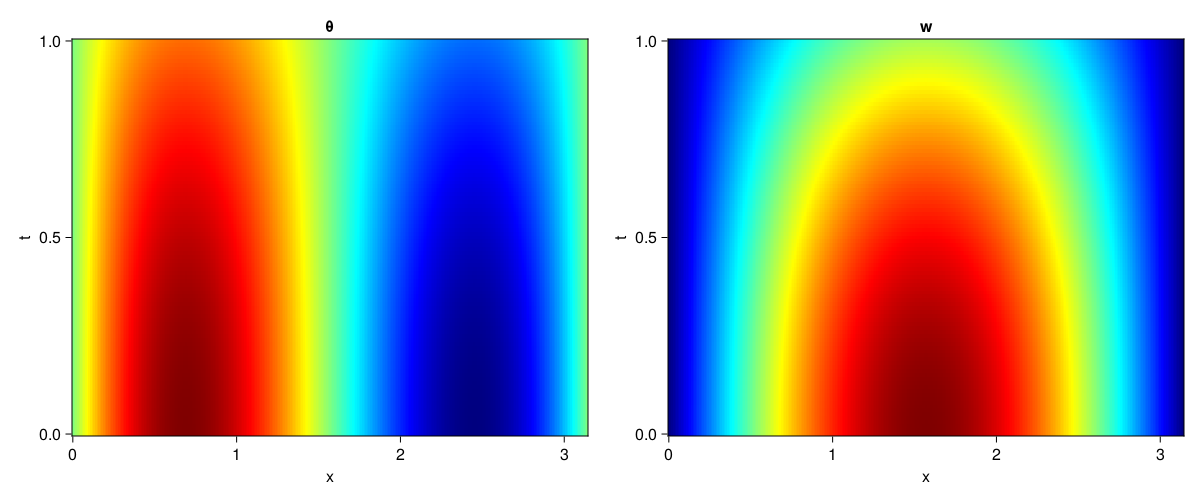

In [44]:
phi = pinn.phi
ps = res.u

xs, ts= [infimum(d.domain):0.01:supremum(d.domain) for d in timo.domain]

θ = [sum(phi.θ(([x,t]), ps.θ)) for x in xs, t in ts]
w = [sum(phi.w(([x,t]), ps.w)) for x in xs, t in ts]

fig = Figure(resolution=(1200,500))
axis = (xlabel="x", ylabel="t", title="θ")
heatmap(fig[1,1], xs, ts, θ, axis=axis, colormap=:jet)
heatmap(fig[1, 2], xs, ts, w, axis= merge(axis, (; title="w")), colormap=:jet)
display(fig)

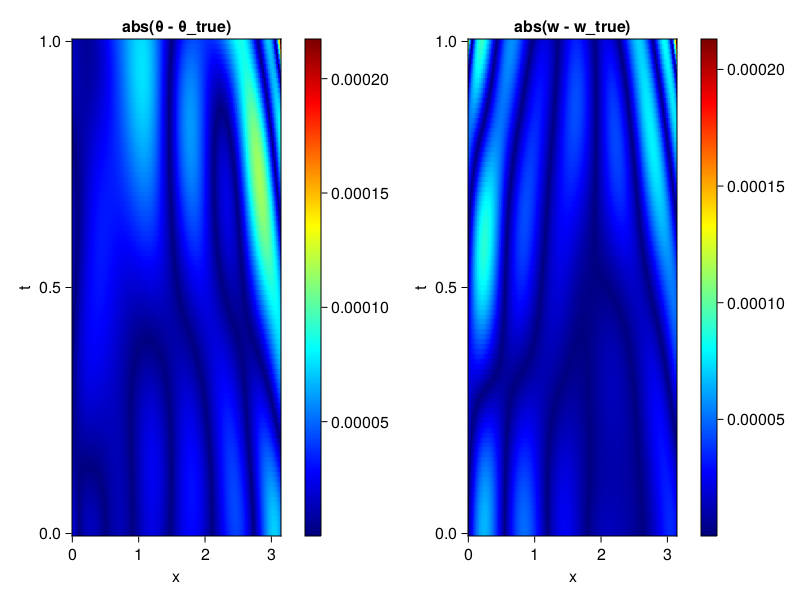

In [45]:
θ_analytic(x,t) = (π/2*cos(x) + x - π/2)*cos(t)
w_analytic(x,t) = π/2*sin(x)*cos(t)

θ_true = [θ_analytic(x,t) for x in xs, t in ts]
w_true = [w_analytic(x,t) for x in xs, t in ts]

axis = (xlabel="x", ylabel="t", title="abs(θ - θ_true)")
fig, ax1, hm1 = heatmap(xs, ts, abs.(θ .- θ_true), axis=axis, colormap=:jet)
Colorbar(fig[:, 2], hm1)
ax2, hm2= heatmap(fig[1, 3], xs, ts, abs.(w .- w_true), axis= merge(axis, (; title="abs(w - w_true)")), colormap=:jet)
Colorbar(fig[:, 4], hm2)
display(fig)

In [46]:
print(res.u.α.constant)

[0.9994569400180221;;]